# VGG16

Create VGG16 version of model for use with DeConvNet sample code
This notebook is based on ESC_25_resnet18_02

## Download Data (takes a LONG time)

In [1]:
#!wget https://github.com/karoldvl/ESC-50/archive/master.zip

In [2]:
#!unzip master.zip

## Imports

In [2]:
%cd /home/jupyter/dev/tflow/deconvnet/Deconvnet-keras
import os
import datetime
from pathlib import Path
from os import path
import pickle
from datetime import datetime
import pandas as pd
import numpy as np
import librosa
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Reshape, Input
from tensorflow.keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from IPython.display import clear_output
import matplotlib.pyplot as plt
import librosa.display
%load_ext tensorboard

/home/jupyter/dev/tflow/deconvnet/Deconvnet-keras


## Data prep

In [3]:
ROOT_DIR = Path("/home/jupyter/")
PATH_ESC50 = ROOT_DIR/"AudioCategoriserEquipment/ESC-50-master"
PATH_ESC50_AUDIO = PATH_ESC50/"audio"
PATH_ESC50_CSV  = PATH_ESC50/"meta/esc50.csv"
print(os.path.exists(PATH_ESC50))

True


In [4]:
esc50_df = pd.read_csv(PATH_ESC50_CSV)
print(esc50_df)

               filename  fold  target        category  esc10  src_file take
0      1-100032-A-0.wav     1       0             dog   True    100032    A
1     1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2     1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3     1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4     1-101296-A-19.wav     1      19    thunderstorm  False    101296    A
...                 ...   ...     ...             ...    ...       ...  ...
1995   5-263831-B-6.wav     5       6             hen  False    263831    B
1996  5-263902-A-36.wav     5      36  vacuum_cleaner  False    263902    A
1997   5-51149-A-25.wav     5      25       footsteps  False     51149    A
1998    5-61635-A-8.wav     5       8           sheep  False     61635    A
1999     5-9032-A-0.wav     5       0             dog   True      9032    A

[2000 rows x 7 columns]


In [5]:
IMAGE_CACHE = path.join(ROOT_DIR, "dev/tflow/cache/")
!mkdir -p {IMAGE_CACHE}

In [6]:
esc25_categories =[
 'breathing',
 'car_horn',
 'cat',
 'chainsaw',
 'chirping_birds',
 'clapping',
 'coughing',
 'cow',
 'crickets',
 'dog',
 'door_wood_knock',
 'engine',
 'frog',
 'glass_breaking',
 'hen',
 'laughing',
 'rain',
 'rooster',
 'sheep',
 'siren',
 'sneezing',
 'snoring',
 'thunderstorm',
 'vacuum_cleaner',
  'wind']

In [7]:
esc25_df = esc50_df[esc50_df.category.isin(esc25_categories)]
print(esc25_df)

               filename  fold  target        category  esc10  src_file take
0      1-100032-A-0.wav     1       0             dog   True    100032    A
1     1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2     1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3     1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4     1-101296-A-19.wav     1      19    thunderstorm  False    101296    A
...                 ...   ...     ...             ...    ...       ...  ...
1994   5-263831-A-6.wav     5       6             hen  False    263831    A
1995   5-263831-B-6.wav     5       6             hen  False    263831    B
1996  5-263902-A-36.wav     5      36  vacuum_cleaner  False    263902    A
1998    5-61635-A-8.wav     5       8           sheep  False     61635    A
1999     5-9032-A-0.wav     5       0             dog   True      9032    A

[1000 rows x 7 columns]


In [8]:
from IPython.display import clear_output
import librosa

def extract_feature(filename):
    y, sr = librosa.load(filename, sr=44100)   
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S = librosa.power_to_db(S)
    S = np.transpose(S)
    S = np.expand_dims(S, 2)
    #S = tf.image.grayscale_to_rgb(S)
    return S

def get_feature_from_row(row):
    filename = PATH_ESC50_AUDIO/row['filename']
    category_label = row['category']
    data = extract_feature(filename)
    return (data, category_label)

def get_feature_set(metadata):
    number_of_rows = len(metadata)
    processed_rows = 0
    validation_set = []
    training_set = []
    for index, row in metadata.iterrows():
        processed_rows += 1  
        clear_output(wait=True)
        if row["fold"] == 1:  
            validation_set.append(get_feature_from_row(row))
        else:
            training_set.append(get_feature_from_row(row))
        progress = float(100 * processed_rows) / number_of_rows
        print(f"Current process: {progress:.2f}%")
    return validation_set, training_set

In [12]:
validation_set, training_set = get_feature_set(esc25_df)

Current process: 100.00%


In [13]:
import random
random.shuffle(training_set)
len(training_set)

800

In [14]:
le = LabelEncoder()
train_x = np.array([data for data, label in training_set])
train_y = to_categorical(le.fit_transform(np.array([label for data, label in training_set])))
test_x = np.array([data for data, label in validation_set])
test_y = to_categorical(le.fit_transform(np.array([label for data, label in validation_set])))
print(test_y.shape)
print(train_y.shape)
print(test_x.shape)
print(train_x.shape)

(200, 25)
(800, 25)
(200, 431, 128, 1)
(800, 431, 128, 1)


#### Shaping the data

In [15]:
timestamp = datetime.now().strftime("%d-%m-%y-%H-%M")
save_data = open(f"esc-25-a-{timestamp}.pickle", "wb")
pickle.dump((test_x, test_y, train_x, train_y), save_data)
save_data.close()

## Building the model

In [9]:
test_x, test_y, train_x, train_y = pickle.load(open("../../esc-25-a-11-06-20-10-28.pickle", "rb"))

In [10]:
train_x.shape

(800, 431, 128, 1)

In [11]:
from tensorflow.keras.applications import vgg16

num_epochs = 40
num_batch_size = 32

num_labels = len(train_y[0])

input_layer = Input(shape=train_x.shape[1:])
#reshape_layer = Reshape((train_x.shape[1], train_x.shape[2], 3), input_shape = train_x.shape[1:])
reshape_layer = Conv2D(filters=3, kernel_size=1, input_shape=(train_x.shape[1:]))
base_model = vgg16.VGG16(input_shape=(431,128,3), weights='imagenet', include_top=False)
base_model.trainable = True

out = reshape_layer(input_layer)
out = base_model(out)
out = GlobalAveragePooling2D()(out)
out = Dropout(0.7)(out) #do we need this?
predictions = Dense(num_labels, activation='softmax')(out)

model = Model(inputs = input_layer, outputs = predictions)

58892288/58889256 [==============================] - 3s 0us/step


In [18]:
#TODO - Add Training rate
learning_rate = ExponentialDecay(
    initial_learning_rate=1e-5,
    decay_steps=num_epochs,
    decay_rate=0.95)

optimizer = Adam(learning_rate=learning_rate)

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)

model.summary()
score = model.evaluate(test_x, test_y, verbose=0)
accuracy = 100*score[1]
print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 431, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 431, 128, 3)       6         
_________________________________________________________________
vgg16 (Model)                (None, 13, 4, 512)        14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 25)                12825     
Total params: 14,727,519
Trainable params: 14,727,519
Non-trainable params: 0
_________________________________________________

## Training

In [13]:
# Use generator instead of plain data array for training
import math
import random
class AugmentedData(Sequence):
    
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = np.copy(self.x[idx * self.batch_size:(idx + 1) *
        self.batch_size])
        batch_y = self.y[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        
        batch_x = self._frequency_mask(batch_x)
        batch_x = self._roll(batch_x)
        return batch_x, batch_y
    
    def _roll(self, batch_x, max_shift_pct=0.7):
        direction = random.choice([-1, 1])
        width, height, c  = batch_x.shape[1:]
        roll_by = int(width*random.random()*max_shift_pct*direction)
        return tf.roll(batch_x, roll_by, axis=1)

    def _frequency_mask(self, batch_x, num_rows=8):
        channel_mean = np.mean(batch_x) #batch_x.contiguous().view(batch_x.size(0), -1).mean(-1).unsqueeze(-1).unsqueeze(-1)
        x, y, c  = batch_x.shape[1:]
        mask = tf.ones([x, num_rows,1]) * channel_mean
        mask = tf.expand_dims(mask, 0)
        start_row = random.randint(0, y-num_rows)
        batch_x[:,:,start_row:start_row+num_rows,:] = mask
        return batch_x

In [14]:
augmented_train = AugmentedData(train_x, train_y, num_batch_size)

In [15]:
def generate_image(spectro):
    plt.axis('off')
    plt.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[])
    librosa.display.specshow(spectro)
    plt.plot()

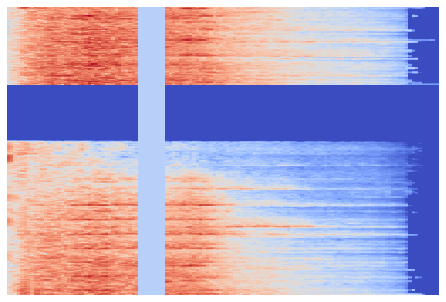

In [16]:
a = tf.squeeze(augmented_train[0][0][0],2)
a.shape
generate_image(np.array(a))

In [19]:
!rm -r logs/*
logdir = os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

start = datetime.now()

model.fit(augmented_train, epochs=num_epochs, \
          validation_data=(test_x, test_y), callbacks=[tensorboard_callback], verbose=1)

duration = datetime.now() - start

print("Training completed in time: ", duration)

Epoch 1/40
25/25 [==============================] - 13s 506ms/step - loss: 3.2095 - accuracy: 0.0538 - val_loss: 3.1981 - val_accuracy: 0.0450
Epoch 2/40
25/25 [==============================] - 13s 506ms/step - loss: 3.2026 - accuracy: 0.0437 - val_loss: 3.1903 - val_accuracy: 0.0500
Epoch 3/40
25/25 [==============================] - 13s 509ms/step - loss: 3.1989 - accuracy: 0.0437 - val_loss: 3.1845 - val_accuracy: 0.0550
Epoch 4/40
25/25 [==============================] - 13s 512ms/step - loss: 3.1922 - accuracy: 0.0413 - val_loss: 3.1834 - val_accuracy: 0.0600
Epoch 5/40
25/25 [==============================] - 13s 513ms/step - loss: 3.1877 - accuracy: 0.0450 - val_loss: 3.1708 - val_accuracy: 0.0500
Epoch 6/40
25/25 [==============================] - 13s 517ms/step - loss: 3.1923 - accuracy: 0.0388 - val_loss: 3.1615 - val_accuracy: 0.0750
Epoch 7/40
25/25 [==============================] - 13s 516ms/step - loss: 3.1676 - accuracy: 0.0437 - val_loss: 3.1398 - val_accuracy: 0.0700

In [20]:
model.fit(augmented_train, epochs=20, \
          validation_data=(test_x, test_y), verbose=1)


Epoch 1/20
25/25 [==============================] - 12s 465ms/step - loss: 2.1110 - accuracy: 0.3875 - val_loss: 2.2681 - val_accuracy: 0.4600
Epoch 2/20
25/25 [==============================] - 12s 469ms/step - loss: 2.1081 - accuracy: 0.3738 - val_loss: 2.2614 - val_accuracy: 0.4650
Epoch 3/20
25/25 [==============================] - 12s 470ms/step - loss: 2.1134 - accuracy: 0.3650 - val_loss: 2.2455 - val_accuracy: 0.4650
Epoch 4/20
25/25 [==============================] - 12s 473ms/step - loss: 2.0522 - accuracy: 0.3850 - val_loss: 2.1767 - val_accuracy: 0.4700
Epoch 5/20
25/25 [==============================] - 12s 475ms/step - loss: 2.0139 - accuracy: 0.3975 - val_loss: 2.1577 - val_accuracy: 0.5000
Epoch 6/20
25/25 [==============================] - 12s 477ms/step - loss: 2.0393 - accuracy: 0.3812 - val_loss: 2.1853 - val_accuracy: 0.4950
Epoch 7/20
25/25 [==============================] - 12s 480ms/step - loss: 2.0149 - accuracy: 0.3900 - val_loss: 2.1349 - val_accuracy: 0.5050

In [21]:
model.fit(augmented_train, epochs=10, \
          validation_data=(test_x, test_y), callbacks=[tensorboard_callback], verbose=1)


Epoch 1/10
25/25 [==============================] - 13s 503ms/step - loss: 1.8033 - accuracy: 0.4475 - val_loss: 1.9002 - val_accuracy: 0.5550
Epoch 2/10
25/25 [==============================] - 13s 507ms/step - loss: 1.7941 - accuracy: 0.4487 - val_loss: 1.8832 - val_accuracy: 0.5500
Epoch 3/10
25/25 [==============================] - 13s 509ms/step - loss: 1.7871 - accuracy: 0.4487 - val_loss: 1.8812 - val_accuracy: 0.5250
Epoch 4/10
25/25 [==============================] - 13s 510ms/step - loss: 1.7354 - accuracy: 0.4737 - val_loss: 1.8474 - val_accuracy: 0.5500
Epoch 5/10
25/25 [==============================] - 13s 512ms/step - loss: 1.7288 - accuracy: 0.4563 - val_loss: 1.8416 - val_accuracy: 0.5450
Epoch 6/10
25/25 [==============================] - 13s 515ms/step - loss: 1.7566 - accuracy: 0.4563 - val_loss: 1.8378 - val_accuracy: 0.5600
Epoch 7/10
25/25 [==============================] - 13s 518ms/step - loss: 1.7169 - accuracy: 0.4725 - val_loss: 1.8453 - val_accuracy: 0.5650

In [22]:
timestamp = datetime.now().strftime("%d-%m-%y-%H-%M")
model.save(f"/home/jupyter/dev/tflow/saved-models/esc_25_vgg16-{timestamp}") 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/jupyter/dev/tflow/saved-models/esc_25_vgg16-03-08-20-14-35/assets


### different LR

In [26]:
from tensorflow.keras.applications import vgg16

num_epochs = 40
num_batch_size = 32

num_labels = len(train_y[0])

input_layer = Input(shape=train_x.shape[1:])
#reshape_layer = Reshape((train_x.shape[1], train_x.shape[2], 3), input_shape = train_x.shape[1:])
reshape_layer = Conv2D(filters=3, kernel_size=1, input_shape=(train_x.shape[1:]))
base_model = vgg16.VGG16(input_shape=(431,128,3), weights='imagenet', include_top=False)
base_model.trainable = True

out = reshape_layer(input_layer)
out = base_model(out)
out = GlobalAveragePooling2D()(out)
out = Dropout(0.7)(out) #do we need this?
predictions = Dense(num_labels, activation='softmax')(out)

model = Model(inputs = input_layer, outputs = predictions)

In [27]:
#TODO - Add Training rate
learning_rate = ExponentialDecay(
    initial_learning_rate=3e-5,
    decay_steps=num_epochs,
    decay_rate=0.95)

optimizer = Adam(learning_rate=learning_rate)

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)

model.summary()
score = model.evaluate(test_x, test_y, verbose=0)
accuracy = 100*score[1]
print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 431, 128, 1)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 431, 128, 3)       6         
_________________________________________________________________
vgg16 (Model)                (None, 13, 4, 512)        14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                12825     
Total params: 14,727,519
Trainable params: 14,727,519
Non-trainable params: 0
_______________________________________________

In [28]:
model.fit(augmented_train, epochs=10, \
          validation_data=(test_x, test_y), verbose=1)

Epoch 1/10
25/25 [==============================] - 12s 468ms/step - loss: 3.4236 - accuracy: 0.0437 - val_loss: 3.1967 - val_accuracy: 0.0300
Epoch 2/10
25/25 [==============================] - 12s 469ms/step - loss: 3.2066 - accuracy: 0.0512 - val_loss: 3.1865 - val_accuracy: 0.0600
Epoch 3/10
25/25 [==============================] - 12s 472ms/step - loss: 3.1819 - accuracy: 0.0425 - val_loss: 3.1422 - val_accuracy: 0.0650
Epoch 4/10
25/25 [==============================] - 12s 476ms/step - loss: 3.1614 - accuracy: 0.0725 - val_loss: 3.1162 - val_accuracy: 0.1400
Epoch 5/10
25/25 [==============================] - 12s 479ms/step - loss: 3.1259 - accuracy: 0.0725 - val_loss: 3.1396 - val_accuracy: 0.1000
Epoch 6/10
25/25 [==============================] - 12s 481ms/step - loss: 3.1399 - accuracy: 0.0688 - val_loss: 3.0497 - val_accuracy: 0.1200
Epoch 7/10
25/25 [==============================] - 12s 483ms/step - loss: 3.0412 - accuracy: 0.0975 - val_loss: 2.9037 - val_accuracy: 0.1700

In [29]:
model.fit(augmented_train, epochs=20, \
          validation_data=(test_x, test_y), verbose=1)

Epoch 1/20
25/25 [==============================] - 12s 488ms/step - loss: 2.2705 - accuracy: 0.3462 - val_loss: 2.0897 - val_accuracy: 0.4900
Epoch 2/20
25/25 [==============================] - 12s 489ms/step - loss: 2.0644 - accuracy: 0.3950 - val_loss: 1.7625 - val_accuracy: 0.5200
Epoch 3/20
25/25 [==============================] - 12s 489ms/step - loss: 1.8564 - accuracy: 0.4500 - val_loss: 1.5197 - val_accuracy: 0.6250
Epoch 4/20
25/25 [==============================] - 12s 489ms/step - loss: 1.5287 - accuracy: 0.5688 - val_loss: 1.2637 - val_accuracy: 0.6800
Epoch 5/20
25/25 [==============================] - 12s 490ms/step - loss: 1.4777 - accuracy: 0.5500 - val_loss: 1.2687 - val_accuracy: 0.6950
Epoch 6/20
25/25 [==============================] - 12s 491ms/step - loss: 1.2140 - accuracy: 0.6313 - val_loss: 1.0787 - val_accuracy: 0.7300
Epoch 7/20
25/25 [==============================] - 12s 493ms/step - loss: 1.0677 - accuracy: 0.6650 - val_loss: 0.8125 - val_accuracy: 0.7900

In [30]:
model.fit(augmented_train, epochs=10, \
          validation_data=(test_x, test_y), verbose=1)

Epoch 1/10
25/25 [==============================] - 12s 488ms/step - loss: 0.2703 - accuracy: 0.9200 - val_loss: 0.6454 - val_accuracy: 0.8450
Epoch 2/10
25/25 [==============================] - 12s 490ms/step - loss: 0.2561 - accuracy: 0.9212 - val_loss: 0.6001 - val_accuracy: 0.8550
Epoch 3/10
25/25 [==============================] - 12s 489ms/step - loss: 0.2699 - accuracy: 0.9212 - val_loss: 0.5975 - val_accuracy: 0.8500
Epoch 4/10
25/25 [==============================] - 12s 491ms/step - loss: 0.2356 - accuracy: 0.9250 - val_loss: 0.5748 - val_accuracy: 0.8600
Epoch 5/10
25/25 [==============================] - 12s 493ms/step - loss: 0.2231 - accuracy: 0.9350 - val_loss: 0.6144 - val_accuracy: 0.8800
Epoch 6/10
25/25 [==============================] - 12s 495ms/step - loss: 0.2273 - accuracy: 0.9275 - val_loss: 0.6058 - val_accuracy: 0.8500
Epoch 7/10
25/25 [==============================] - 12s 496ms/step - loss: 0.1858 - accuracy: 0.9425 - val_loss: 0.5745 - val_accuracy: 0.8850

In [31]:
timestamp = datetime.now().strftime("%d-%m-%y-%H-%M")
model.save(f"/home/jupyter/dev/tflow/saved-models/esc_25_vgg16-{timestamp}") 

INFO:tensorflow:Assets written to: /home/jupyter/dev/tflow/saved-models/esc_25_vgg16-03-08-20-14-49/assets


## Convert to TFLite

In [32]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

In [33]:
tflite_model = converter.convert()

In [35]:
timestamp = datetime.now().strftime("%d-%m-%y-%H-%M")
with open(f"/home/jupyter/dev/tflow/saved-models/esc_25_vgg16-{timestamp}.tflite", "wb") as f:
    f.write(tflite_model)

# Testing script

In [36]:
import glob
from pathlib import Path
from os import path

In [37]:
recordings_dir = "/home/jupyter/AudioCategoriserEquipment-AudioSamples/"

In [38]:
audio_filepaths = []
for filepath in Path(recordings_dir).rglob('*.wav'):
    audio_filepaths.append(str(filepath))

In [39]:
filepaths_with_cat = [(filepath, path.dirname(filepath).split("/")[-1]) for filepath in audio_filepaths]

In [40]:
import numpy as np
import librosa

try:
    import tflite_runtime.interpreter as tflite
except ModuleNotFoundError:
    import tensorflow.lite as tflite

MODEL_PATH = "/home/jupyter/dev/tflow/saved-models/esc_25_vgg16-03-08-20-14-52.tflite"

def extract_feature(filename):
    y, sr = librosa.load(filename, sr=44100)   
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S = librosa.power_to_db(S)
    S = np.transpose(S)
    return S[np.newaxis, 0:431, :, np.newaxis]


def get_human_readable_output(output):
    results = [
        'breathing', 'car_horn', 'cat',
        'chainsaw', 'chirping_birds',
        'clapping', 'coughing', 'cow',
        'crickets', 'dog', 'door_wood_knock',
        'engine', 'frog', 'glass_breaking',
        'hen', 'laughing', 'rain', 'rooster',
        'sheep', 'siren', 'sneezing',
        'snoring', 'thunderstorm',
        'vacuum_cleaner', 'wind'
    ]

    output = list(output[0])

    largest = max(output)
    index = list(output).index(largest)
    return results[index]
    #result = f"{largest * 100:.2f}% confident that this is a {results[index]}"

    #formatted_output = [f"{o*100:05.2f}" for o in output]
    #stats = [f"{x}%: {results[i]}" for i, x in enumerate(formatted_output)]

    #return result, "\n".join(stats)


def infer_from_file(filename, model_path=MODEL_PATH):
    interpreter = tflite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    input_data = extract_feature(filename)

    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    predicted_data_vector = interpreter.get_tensor(output_details[0]['index'])

    return get_human_readable_output(predicted_data_vector)

In [41]:
import time

start = time.time()
results = []
for filepath, cat in filepaths_with_cat:
    results.append((infer_from_file(filepath), cat))
end = time.time()

In [42]:
correct = 0
for result, expected in results:
    if result == expected: correct +=1 
        
print(f"Got {correct} out of {len(results)}")
print(f"{correct/len(results)*100:.2f}% correct")
print(f"Took {end - start}")

Got 98 out of 192
51.04% correct
Took 199.495685338974


esc_25_simple_05:

    Got 88 out of 192
    45.83% correct
    Took 88.54123330116272
    
esc_25_resnet18-02-24-07-20-13-26:

    Got 88 out of 192
    45.83% correct
    Took 50.27479147911072